# 4장. Working Area Inspection
우선, 인공지능 무인운반차량(AGV)을 수동 조작하여 map에 있는 색상 값의 HSV 값을 조사하도록 하겠습니다.

## 라이브러리 가져오기

In [1]:
from IPython.display import display
import ipywidgets
import ipywidgets.widgets as widgets
import traitlets
from robotpal import Robot, Camera, bgr8_to_jpeg
from robotpal.SCSCtrl import TTLServo

import threading
import cv2
import numpy as np
import time

[RobotPal] 서버 시작됨 | WebSocket: 9999, TCP: 9998
[RobotPal] 통신 대기 중... (WS: 9999, TCP: 9998)


[System] WebSocket 프로세서 시작


In [2]:
robot = Robot()
camera = Camera()
TTLServo.servoAngleCtrl(5, 45, 1, 100)

# 최대, 최소 HSV 값 표시하는 레이블 생성
lbl1 = ipywidgets.Label(value="Max :")
colorlblMax = ipywidgets.Label(value="0")
hbox1 = widgets.HBox([lbl1, colorlblMax] )

lbl2 = ipywidgets.Label(value="Min :")
colorlblMin = ipywidgets.Label(value="0")
hbox2 = widgets.HBox([lbl2, colorlblMin])

image_widget = ipywidgets.Image(format='jpeg', width=224, height=224)
vbox1 = widgets.VBox([hbox1, hbox2, image_widget])

#수동 조작용 버튼 생성
lbl4 = ipywidgets.Label(value="Manual Controller")
button_layout = widgets.Layout(width='100px', height='80px', align_self='center')
stop_button = widgets.Button(description='stop', button_style='danger', layout=button_layout)
forward_button = widgets.Button(description='forward', layout=button_layout)
backward_button = widgets.Button(description='backward', layout=button_layout)
left_button = widgets.Button(description='left', layout=button_layout)
right_button = widgets.Button(description='right', layout=button_layout)

middle_box = widgets.HBox([left_button, stop_button, right_button], layout=widgets.Layout(align_self='center'))
controls_box = widgets.VBox([lbl4,forward_button, middle_box, backward_button])
hbox4 = widgets.HBox([vbox1, controls_box])
display(hbox4)

manual_btnlst = [stop_button, forward_button, backward_button, left_button, right_button]
camera_link = traitlets.dlink((camera, 'value'), (image_widget, 'value'), transform=bgr8_to_jpeg)

## colorRecog() 클래스 생성하기

In [3]:
def stop(change):
    robot.stop()
    
def step_forward(change):
    robot.forward(0.4)

def step_backward(change):
    robot.backward(0.4)

def step_left(change):
    robot.left(0.3)
    time.sleep(0.5)
    robot.stop()

def step_right(change):
    robot.right(0.3)
    time.sleep(0.5)
    robot.stop()

stop_button.on_click(stop)
forward_button.on_click(step_forward)
backward_button.on_click(step_backward)
left_button.on_click(step_left)
right_button.on_click(step_right)

# 카메라 로 촬영한 frame 크기
frame_width = 224
frame_height = 224

# class 종료 변수
th_flag = True

# HSV 값을 담아줄 리스트
colorHSVvalueList = []

# 최대 측정할 개수
max_len = 20

# WorkingArea 인식용 클래스
def colorRecog():
    while th_flag:
        image = camera.value
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv = cv2.blur(hsv, (15, 15))
        
        # Center Pixel 의 hsv 값 읽어오기
        hsvValue = hsv[int(frame_height/2), int(frame_width/2)]

        # data 20개 모아서, 최대, 최소 값 구하기
        colorHSVvalueList.append(hsvValue)
        if len(colorHSVvalueList) > max_len:
            del colorHSVvalueList[0]
        max_h,max_s,max_v = np.maximum.reduce(colorHSVvalueList)
        min_h,min_s,min_v = np.minimum.reduce(colorHSVvalueList)

        # Center Pixel 주위에 20x20 크기의 사각형 그리기
        rect_s = 20
        cv2.rectangle(image,
                      (int(frame_width/2)-int(rect_s/2),int(frame_height/2)-int(rect_s/2)),
                      (int(frame_width/2)+int(rect_s/2),int(frame_height/2)+int(rect_s/2)),
                      (255,255,255),1)
        
        # max , min value 표시
        cv2.putText(image,f'max_HSV:{ max_h,max_s,max_v }',(20,180), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,255,255),1,cv2.LINE_AA)
        cv2.putText(image,f'min_HSV:{ min_h,min_s,min_v }',(20,200), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(255,255,255),1,cv2.LINE_AA)
        colorlblMax.value = str(max_h)+","+ str(max_s)+","+ str(max_v)
        colorlblMin.value = str(min_h)+","+ str(min_s)+","+ str(min_v)
        
        image_widget.value = bgr8_to_jpeg(image)
        time.sleep(0.01)
        
image_thread = threading.Thread(target = colorRecog)
image_thread.start()

실행 결과  
1. 보라색 영역 감지한 모습  
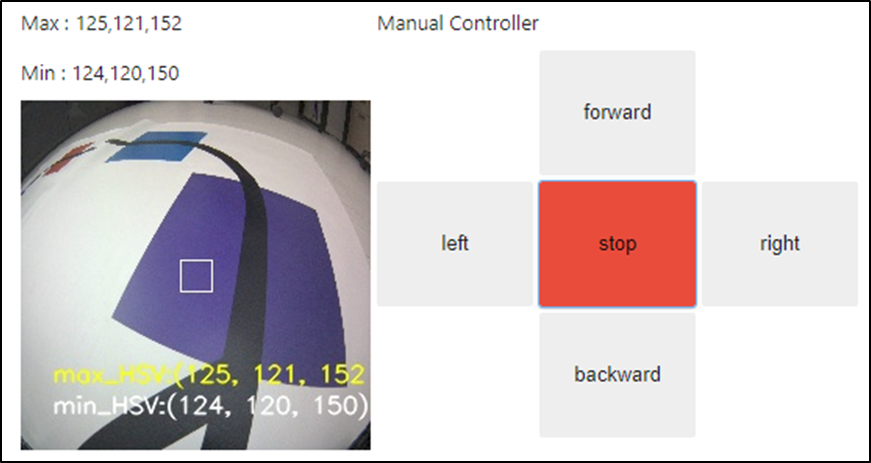

2. 노란색 영역 감지한 모습  
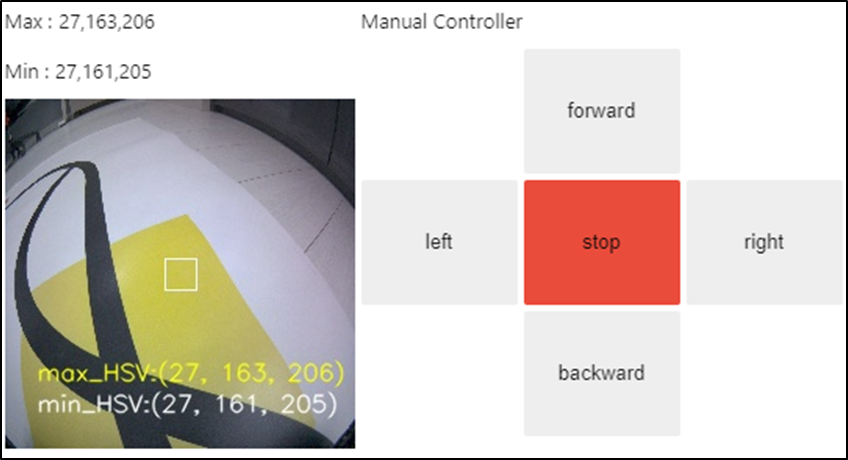

## 프로젝트 종료
Working Area 의 색상 조사를 모두 마쳤으면, 아래 코드를 실행해서 프로젝트를 종료합니다.

In [7]:
th_flag = False
image_thread.join()
time.sleep(0.1)
robot.stop()
camera.stop()